In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import csv
encoding = 'utf-8'
with open('train_data.txt', 'r', encoding=encoding) as file:
    lines = file.readlines()
data = [line.strip().split(':::') for line in lines]
with open('train_data.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

In [4]:
column_name=['ID','TITLE_YEAR','GENRE','DESCRIPTION']

In [5]:
train_data=pd.read_csv('train_data.csv',header=None,names=column_name)

In [6]:
train_data.head(2)

,ID,TITLE_YEAR,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...


In [7]:
train_data.shape

(54214, 4)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54214 non-null  int64 
 1   TITLE_YEAR   54214 non-null  object
 2   GENRE        54214 non-null  object
 3   DESCRIPTION  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [9]:
train_data[['TITLE', 'YEAR']] = train_data['TITLE_YEAR'].str.extract(r'(.+)\((\d+)\)')
train_data.drop('TITLE_YEAR', axis=1, inplace=True)

In [10]:
null_column=train_data.isnull().sum()
print(null_column)

ID                0
GENRE             0
DESCRIPTION       0
TITLE          4347
YEAR           4347
dtype: int64


In [11]:
null_columns = train_data.columns[train_data.isnull().any()]

In [12]:
null_rows_values = train_data.loc[train_data[null_columns].isnull().any(axis=1), null_columns]

In [13]:
null_rows_values

,TITLE,YEAR
9,NaN,NaN
25,NaN,NaN
36,NaN,NaN
38,NaN,NaN
44,NaN,NaN
...,...,...
54187,NaN,NaN
54196,NaN,NaN
54200,NaN,NaN
54203,NaN,NaN


In [14]:
categorical_features_with_missing = ['TITLE']  
imputation_value = 'Unknown'
for feature in categorical_features_with_missing:
    train_data[feature].fillna(imputation_value, inplace=True)

In [15]:
from sklearn.impute import SimpleImputer

In [16]:
imputer = SimpleImputer(missing_values=np.NaN,strategy='most_frequent')
train_data['YEAR'] = imputer.fit_transform(train_data['YEAR'].values.reshape(-1,1))[:,0]

In [17]:
from nltk.corpus import stopwords
from nltk import RegexpTokenizer

In [18]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

In [19]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['DESCRIPTION'].apply(clean_text)

In [20]:
train_data.GENRE.value_counts()[0:10]

GENRE
 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
Name: count, dtype: int64

Text(0.5, 1.05, 'GENRE')

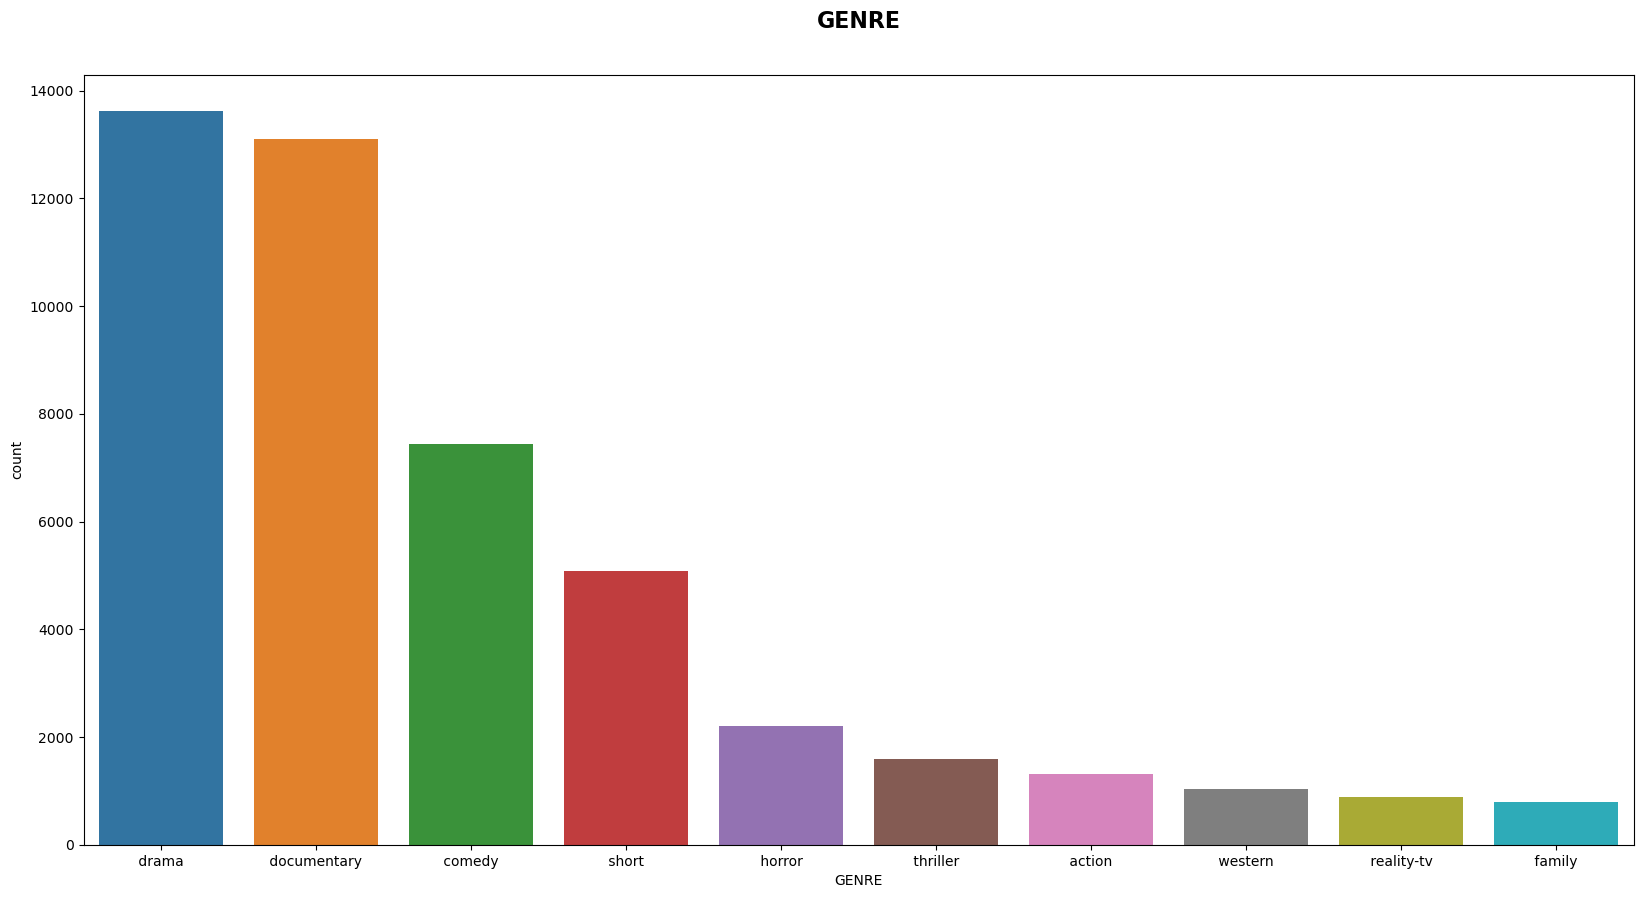

In [21]:
plt.figure(figsize=(20,10))
pt=sns.countplot(data=train_data,x='GENRE',order=train_data.GENRE.value_counts(sort=True,ascending=False).index[0:10])
pt.set_title('GENRE', fontsize=16, fontweight='bold', y=1.05)

In [22]:
train_data.YEAR.value_counts()[0:10]

YEAR
2016    7395
2017    3018
2015    2740
2014    2324
2009    2254
2012    2220
2013    2218
2008    2151
2011    2148
2010    1930
Name: count, dtype: int64

Text(0.5, 1.05, 'YEAR')

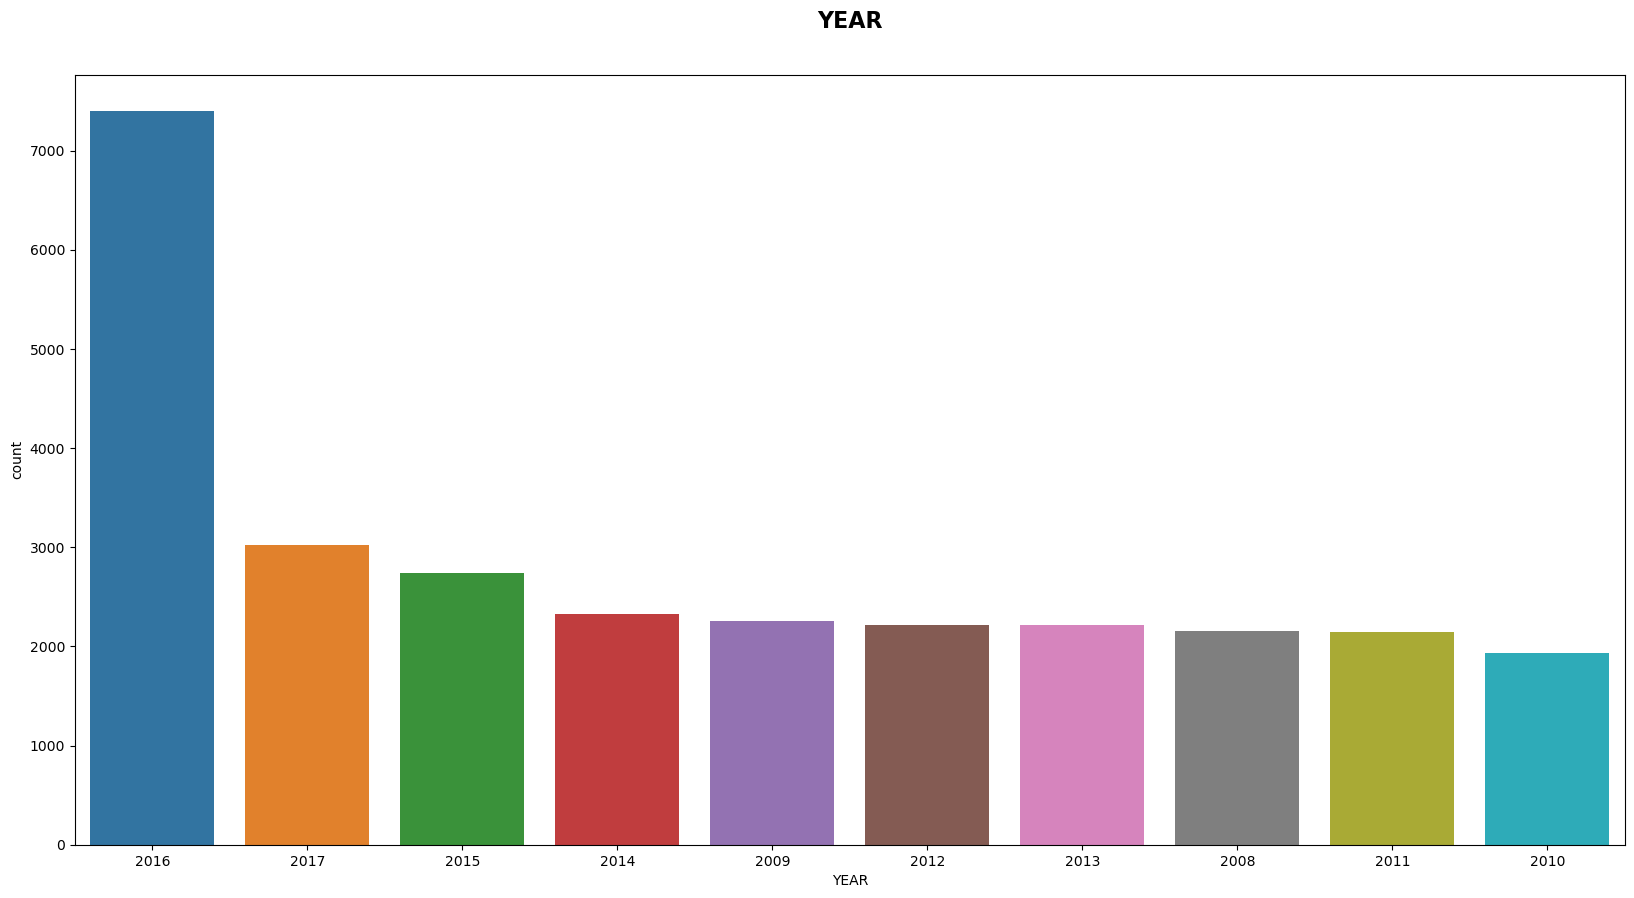

In [23]:
plt.figure(figsize=(20,10))
pt=sns.countplot(data=train_data,x='YEAR',order=train_data.YEAR.value_counts(sort=True,ascending=False).index[0:10])
pt.set_title('YEAR', fontsize=16, fontweight='bold', y=1.05)

In [24]:
from collections import Counter

Text(0.5, 1.05, 'Year vs Genre')

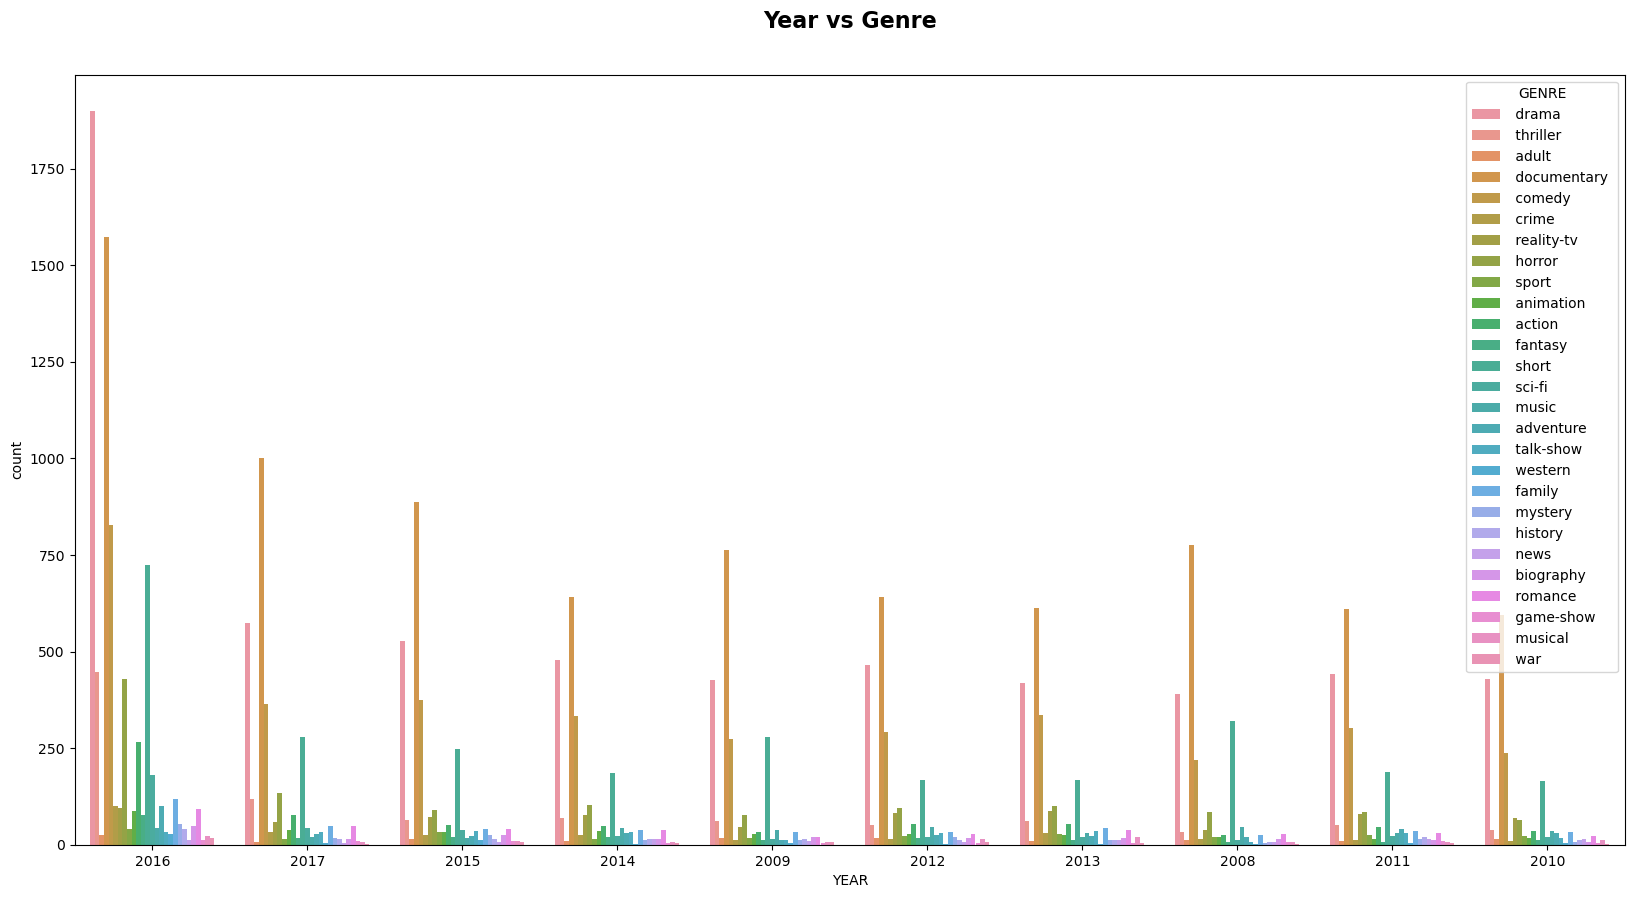

In [25]:
plt.figure(figsize=(20,10))
pt=sns.countplot(data=train_data,x='YEAR',hue='GENRE',order=train_data.YEAR.value_counts(sort=True,ascending=False).index[0:10])
pt.set_title('Year vs Genre', fontsize=16, fontweight='bold', y=1.05)

In [26]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_data['Genre_encoded'] = label_encoder.fit_transform(train_data['GENRE'])
train_data['Genre_encoded']

class_names= list(label_encoder.classes_)
class_names  

[' action ',
 ' adult ',
 ' adventure ',
 ' animation ',
 ' biography ',
 ' comedy ',
 ' crime ',
 ' documentary ',
 ' drama ',
 ' family ',
 ' fantasy ',
 ' game-show ',
 ' history ',
 ' horror ',
 ' music ',
 ' musical ',
 ' mystery ',
 ' news ',
 ' reality-tv ',
 ' romance ',
 ' sci-fi ',
 ' short ',
 ' sport ',
 ' talk-show ',
 ' thriller ',
 ' war ',
 ' western ']

In [27]:
train_data.columns

Index(['ID', 'GENRE', 'DESCRIPTION', 'TITLE', 'YEAR', 'Text_cleaning',
       'Genre_encoded'],
      dtype='object')

In [28]:
tfidf_vectorizer = TfidfVectorizer()

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

In [30]:
train_data['Text_cleaning']

0        listening conversation doctor parents year old...
1        brother sister past incestuous relationship cu...
2        bus empties students field trip museum natural...
3        help unemployed father make ends meet edith tw...
4        films title refers recovered bodies ground zer...
                               ...                        
54209    short lived nbc live sitcom centered bonino wo...
54210    next generation exploitation sisters kapa bay ...
54211    bestaan echt stand comedy growing facing fears...
54212    walter vivian live country difficult time keep...
54213    labor day weekend intense hurricane ever make ...
Name: Text_cleaning, Length: 54214, dtype: object

In [80]:
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

In [81]:
X_train

<54214x124210 sparse matrix of type '<class 'numpy.float64'>'
	with 2640592 stored elements in Compressed Sparse Row format>

In [33]:
y_train=train_data['GENRE']

In [34]:
logistic_reg_pipeline = Pipeline([
    ('classifier', LogisticRegression(max_iter=1000)) # Logistic Regression model
])

svm_pipeline = Pipeline([
    ('classifier', SVC(kernel='linear')) # SVM model
])

naive_bayes_pipeline = Pipeline([
    ('classifier', GaussianNB()) # Naive Bayes model (no need for scaling)
])



In [35]:
pipeline_nb = Pipeline([
    ('classifier', MultinomialNB())
])

pipeline_lr = Pipeline([
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline_svm = Pipeline([
    ('classifier', SVC(kernel='linear'))
])

In [36]:
pipelines = [
    ("Naive Bayes", pipeline_nb),
    ("Logistic Regression", pipeline_lr),
    ("Support Vector Machine", pipeline_svm)
]

In [37]:
for name, pipeline in pipelines:
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    print(f"Evaluating {name}...")


Training Naive Bayes...
Evaluating Naive Bayes...
Training Logistic Regression...
Evaluating Logistic Regression...
Training Support Vector Machine...
Evaluating Support Vector Machine...


In [38]:
def title_year(data,title_year_col):
    data[['TITLE', 'YEAR']] =data[title_year_col].str.extract(r'(.+)\((\d+)\)')
    data.drop(title_year_col, axis=1, inplace=True)
    return data

In [39]:
def categorical_feature(data):
    categorical_features_with_missing = ['TITLE']  
    imputation_value = 'Unknown'
    for feature in categorical_features_with_missing:
        data[feature].fillna(imputation_value, inplace=True)
    return data

In [40]:
def missing_value(data):
    imputer = SimpleImputer(missing_values=np.NaN,strategy='most_frequent')
    data['YEAR'] = imputer.fit_transform(data['YEAR'].values.reshape(-1,1))[:,0]
    return data

In [41]:
from sklearn.preprocessing import FunctionTransformer

In [42]:
pipeline_col = Pipeline([

    ('title_year', FunctionTransformer(title_year, kw_args={'title_year_col': 'TITLE_YEAR'})),
    
    # Rename columns
    ('rename_columns', FunctionTransformer(categorical_feature)),
    ('missing', FunctionTransformer(missing_value)),
    

])

In [43]:
pipeline_col

Pipeline(steps=[('title_year',
                 FunctionTransformer(func=<function title_year at 0x000002D4A7430AF0>,
                                     kw_args={'title_year_col': 'TITLE_YEAR'})),
                ('rename_columns',
                 FunctionTransformer(func=<function categorical_feature at 0x000002D4A6519820>)),
                ('missing',
                 FunctionTransformer(func=<function missing_value at 0x000002D4A7430A60>))])

In [44]:
from sklearn.pipeline import make_pipeline

In [45]:
final_pipeline = make_pipeline(
    pipeline_col,  
)

In [70]:
import csv
encoding = 'utf-8'
with open('test_data.txt', 'r', encoding=encoding) as file:
    lines = file.readlines()
data = [line.strip().split(':::') for line in lines]
with open('test_data.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

In [71]:
column_name=['ID','TITLE_YEAR','DESCRIPTION']

In [72]:
test_data=pd.read_csv('test_data.csv',names=column_name)

In [73]:
test_data.head(2)

,ID,TITLE_YEAR,DESCRIPTION
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."


In [74]:
data=final_pipeline.transform(test_data)

In [75]:
data.head(2)

,ID,DESCRIPTION,TITLE,YEAR
0,1,"L.R. Brane loves his life - his car, his apar...",Edgar's Lunch,1998
1,2,"Spain, March 1964: Quico is a very naughty ch...",La guerra de papá,1977


In [76]:
data['Text_cleaning'] = data['DESCRIPTION'].apply(clean_text)

In [82]:
X_test = tfidf_vectorizer.transform(data['Text_cleaning'])

In [83]:
X_test

<54200x124210 sparse matrix of type '<class 'numpy.float64'>'
	with 2578617 stored elements in Compressed Sparse Row format>

In [84]:
y_pred = pipeline.predict(X_test)

In [87]:
import csv
encoding = 'utf-8'
with open('test_data_solution.txt', 'r', encoding=encoding) as file:
    lines = file.readlines()
data = [line.strip().split(':::') for line in lines]
with open('test_data_solution.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

In [91]:
column_name=['ID','TITLE_YEAR','GENRE','DESCRIPTION']

In [92]:
test_data_solution=pd.read_csv('test_data_solution.csv',names=column_name)

In [93]:
test_data_solution.head(2)

,ID,TITLE_YEAR,GENRE,DESCRIPTION
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."


In [94]:
y_test_data=test_data_solution['GENRE']

In [102]:
from sklearn.metrics import accuracy_score, classification_report

In [103]:
accuracy = accuracy_score(y_test_data, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_test_data, y_pred))

Validation Accuracy: 0.6028044280442805
               precision    recall  f1-score   support

      action        0.47      0.36      0.41      1314
       adult        0.64      0.41      0.50       590
   adventure        0.59      0.23      0.33       775
   animation        0.50      0.11      0.19       498
   biography        0.00      0.00      0.00       264
      comedy        0.55      0.60      0.58      7446
       crime        0.31      0.04      0.06       505
 documentary        0.69      0.86      0.76     13096
       drama        0.56      0.78      0.65     13612
      family        0.53      0.12      0.19       783
     fantasy        0.34      0.06      0.10       322
   game-show        0.86      0.62      0.72       193
     history        0.00      0.00      0.00       243
      horror        0.67      0.62      0.64      2204
       music        0.69      0.50      0.58       731
     musical        0.31      0.02      0.03       276
     mystery        0.33